In [1]:
import pandas as pd
import utils
import matplotlib.pyplot as plt
import os
import dataloader

import torch
import torch.nn as nn
from model import generate_model

from torch.utils.data import DataLoader
from metrics import accuracy

In [2]:
dir_path ='result/' 
result_name = ['resnet18_20221122_0001','resnet18_20221122_0653','resnet18_20221122_1613','resnet18_20221122_2306'] #selector

selector = 1

result_path = os.path.join(dir_path,result_name[selector])
df_train_log = pd.read_csv(os.path.join(result_path,result_name[selector]+'_train.log'),delimiter='\t')
df_valid_log = pd.read_csv(os.path.join(result_path,result_name[selector]+'_valid.log'),delimiter='\t')
df_test_log = pd.read_csv(os.path.join(result_path,result_name[selector]+'_test.log'),delimiter='\t')

model_last_path = os.path.join(result_path,result_name[selector]+'_checkpoint.pth')
model_best_path = os.path.join(result_path,result_name[selector]+'_best.pth')

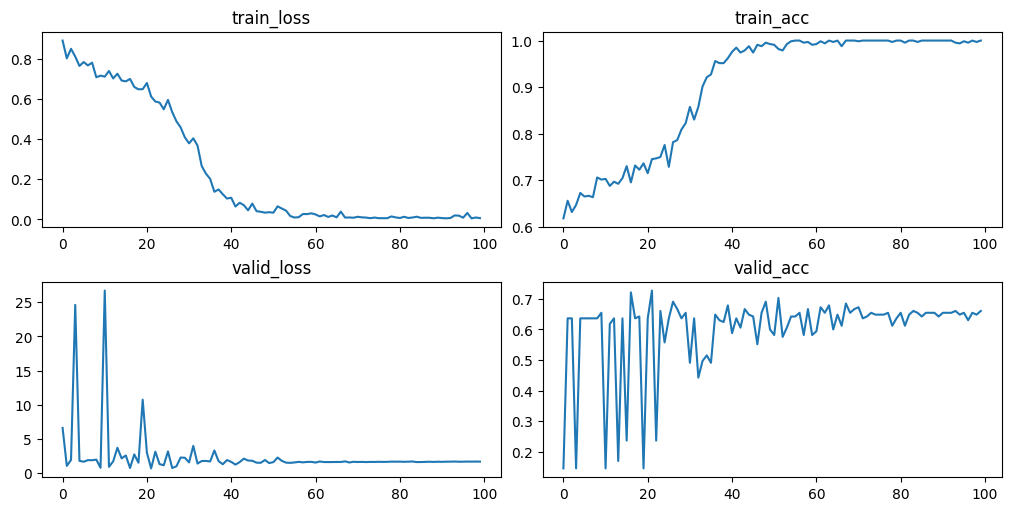

In [3]:
fig,ax = plt.subplots(2,2,figsize=[10,5],constrained_layout=True)
#plt.suptitle('title')
ax[0,0].set_title('train_loss')
ax[0,0].plot(df_train_log['loss'])
ax[0,1].set_title('train_acc')
ax[0,1].plot(df_train_log['acc'])
ax[1,0].set_title('valid_loss')
ax[1,0].plot(df_valid_log['loss'])
ax[1,1].set_title('valid_acc')
ax[1,1].plot(df_valid_log['acc'])
plt.savefig(os.path.join(result_path,'loss_acc_plot.png'))
plt.show()

In [4]:
#데이터셋 분리(Train, validation(internal), test(external))
config = utils.load_config()

df_dataset = pd.read_csv(config['PATH_DATASET_CSV'])
df_dataset = df_dataset.dropna().reset_index(drop=True)
df_oasis = df_dataset[df_dataset['source'] == 'OASIS-3']
df_adni = df_dataset[df_dataset['source'] == 'ADNI']
X_train,X_val,y_train,y_val = dataloader.dataset_split(df_oasis,test_size=0.2,shuffle=True,grp=None,seed=1004)
X_test = df_adni.drop(labels='group_maxinc',axis=1)
y_test = df_adni['group_maxinc']

valdata=dataloader.MRIDataset(X_val,y_val)
testdata=dataloader.MRIDataset(X_test,y_test)

from torch.utils.data import DataLoader
val_dataloader  = DataLoader(valdata, batch_size=1, shuffle=False,num_workers=1)
test_dataloader  = DataLoader(testdata, batch_size=1, shuffle=False,num_workers=1)

print('val_dataloader : ',len(val_dataloader.dataset))
print('test_dataloader : ',len(test_dataloader.dataset))

val_dataloader :  165
test_dataloader :  166


d:\MyGit\BrainMR_MCI\dataloader.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dataset['grp'] = (df_dataset['source'].str.replace('OASIS-3','1').str.replace('ADNI','2').apply(pd.to_numeric)*1000


In [17]:
train_ad,train_cn,train_mci = pd.get_dummies(y_train).sum()

train_total = train_ad + train_cn + train_mci
print('Train Data\n Total: {}    CN : {} ({:.0f}% of total),   MCI: {} ({:.0f}% of total),   AD : {} ({:.0f}% of total)'.format(train_total, train_cn,  100 * train_cn / train_total, train_mci, 100 * train_mci / train_total, train_ad,  100 * train_ad / train_total))


Train Data
 Total: 659    CN : 419 (64% of total),   MCI: 147 (22% of total),   AD : 93 (14% of total)


In [16]:
valid_ad,valid_cn,valid_mci = pd.get_dummies(y_val).sum()

valid_total = valid_ad + valid_cn + valid_mci
print('valid Data\n Total: {}    CN : {} ({:.0f}% of total),   MCI: {} ({:.0f}% of total),   AD : {} ({:.0f}% of total)'.format(valid_total, valid_cn,  100 * valid_cn / valid_total, valid_mci, 100 * valid_mci / valid_total, valid_ad,  100 * valid_ad / valid_total))


valid Data
 Total: 165    CN : 105 (64% of total),   MCI: 36 (22% of total),   AD : 24 (15% of total)


In [18]:
test_ad,test_cn,test_mci = pd.get_dummies(y_test).sum()

test_total = test_ad + test_cn + test_mci
print('test Data\n Total: {}    CN : {} ({:.0f}% of total),   MCI: {} ({:.0f}% of total),   AD : {} ({:.0f}% of total)'.format(test_total, test_cn,  100 * test_cn / test_total, test_mci, 100 * test_mci / test_total, test_ad,  100 * test_ad / test_total))


test Data
 Total: 166    CN : 52 (31% of total),   MCI: 80 (48% of total),   AD : 34 (20% of total)


In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

age_onoff = False
add_last_fc_num = 1 if age_onoff == True else 0
    
model, _ = generate_model(model_name='resnet',model_depth = 18,n_classes=3,resnet_shortcut='B',add_last_fc_num=add_last_fc_num)
model.to(device)

log_path = config['log_path']
criterion_clf = nn.CrossEntropyLoss().to(device)

checkpoint = torch.load(model_best_path, map_location=device)
model.load_state_dict(checkpoint['state_dict'])

cpu


d:\MyGit\BrainMR_MCI\models\resnet.py:143: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  m.weight = nn.init.kaiming_normal(m.weight, mode='fan_out')


RuntimeError: Error(s) in loading state_dict for ResNet:
	size mismatch for fc.weight: copying a param with shape torch.Size([3, 513]) from checkpoint, the shape in current model is torch.Size([3, 512]).

In [ ]:
from model_test import test
test_internal_logger = utils.Logger(os.path.join(result_path, 'test(internal).log'),['best_yn','loss', 'acc','ConfusionMatrix','auroc','fpr','tpr','thresholds'])
test_external_logger = utils.Logger(os.path.join(result_path, 'test(external).log'),['best_yn','loss', 'acc','ConfusionMatrix','auroc','fpr','tpr','thresholds'])

in_loss, in_acc, in_CM, in_auroc, in_fpr, in_tpr, in_thresholds = test(device,val_dataloader,model,criterion_clf, test_internal_logger, age_onoff = age_onoff,best_yn=False)
out_loss, out_acc, out_CM, out_auroc, out_fpr, out_tpr, out_thresholds = test(device,test_dataloader,model,criterion_clf, test_external_logger, age_onoff = age_onoff,best_yn=False)

test
Loss : 1.1067	 Acc : 0.69697	
tensor([[102,   0,   3],
        [ 33,   1,   2],
        [ 11,   1,  12]])
tensor([0.7702, 0.6339, 0.8975])
test
Loss : 3.2843	 Acc : 0.32530	
tensor([[41,  0, 11],
        [56,  0, 24],
        [21,  0, 13]])
tensor([0.6805, 0.5279, 0.6916])


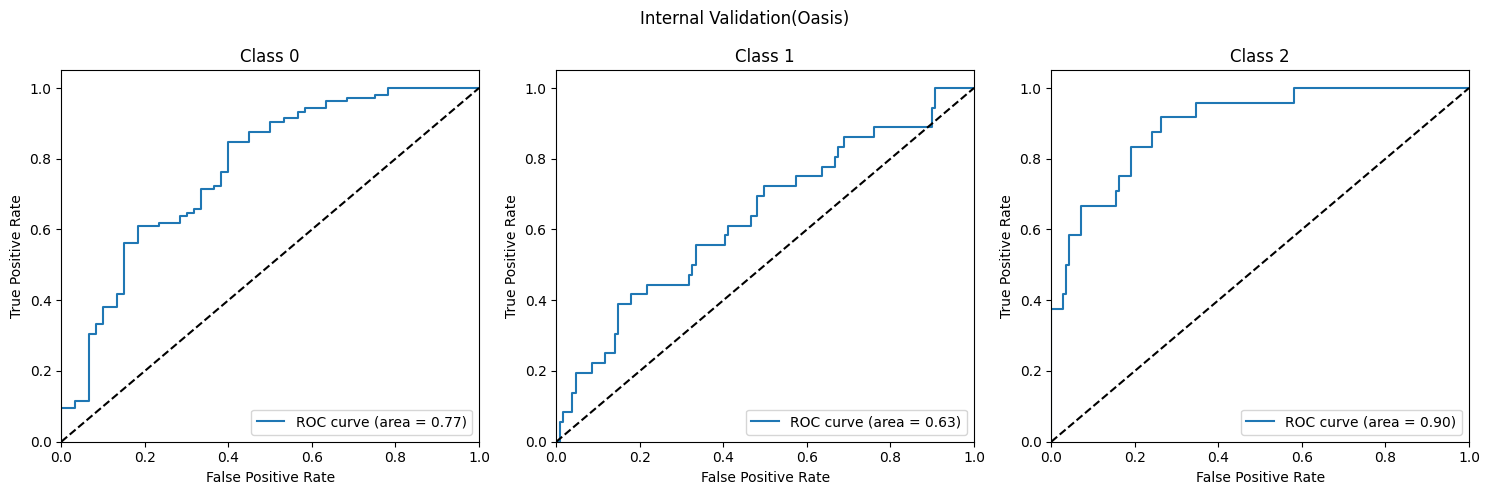

In [ ]:
# Plot of a ROC curve for a specific class
plt.figure(figsize=(15, 5))
for idx, i in enumerate(range(3)):
    plt.subplot(131+idx)
    plt.plot(in_fpr[i], in_tpr[i], label='ROC curve (area = %0.2f)' % in_auroc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Class %0.0f' % idx)
    plt.legend(loc="lower right")

title = 'Internal Validation(Oasis)'
plt.suptitle(title)
plt.tight_layout()
plt.savefig(os.path.join(result_path,title+'.png'))
plt.show()

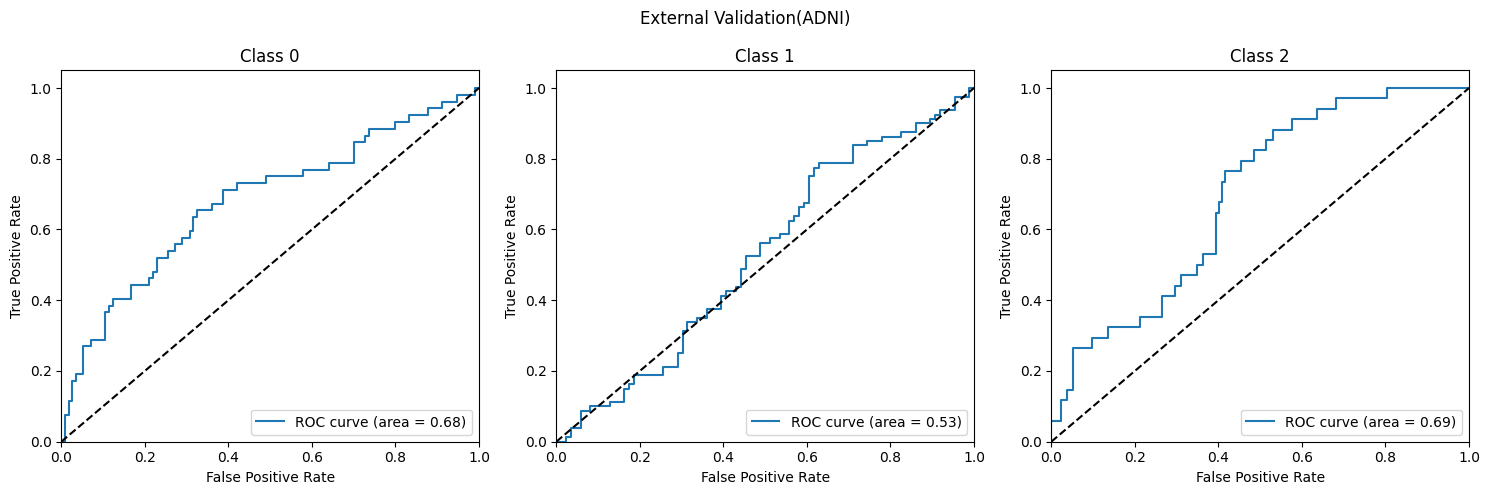

In [ ]:
# Plot of a ROC curve for a specific class
plt.figure(figsize=(15, 5))
for idx, i in enumerate(range(3)):
    plt.subplot(131+idx)
    plt.plot(out_fpr[i], out_tpr[i], label='ROC curve (area = %0.2f)' % out_auroc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Class %0.0f' % idx)
    plt.legend(loc="lower right")

title = 'External Validation(ADNI)'
plt.suptitle(title)
plt.tight_layout()
plt.savefig(os.path.join(result_path,title+'.png'))
plt.show()